## **dependencies**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
pd.set_option('future.no_silent_downcasting', True)
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, metrics, models, optimizers, losses
import matplotlib.pyplot as plt
import sklearn.metrics
!pip install graphviz
import graphviz
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## **Data ingestion**

In [2]:
data = pd.read_csv('BO_Training_Dataset.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print("Number of categorical featues including Product id and target variable : " , data.select_dtypes(exclude=['int', 'float']).shape[1])
print('Features : ', data.columns.values)

Number of data points :  1048575
Number of features :  23
Number of categorical featues including Product id and target variable :  7
Features :  ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


## **Subset of data (50,000 data points)**

In [3]:
data = data[:50000]

## **Data processing pipeline**

In [4]:
# 1
data = data.drop(columns=['sku'])

# 2
num_features = data.select_dtypes(include=['float64', 'int64'])

# 3
data.loc[:, 'perf_12_month_avg'] = data['perf_12_month_avg'].replace(-99.0, np.nan)
data.loc[:, 'perf_6_month_avg'] = data['perf_6_month_avg'].replace(-99.0, np.nan)

# 4
imputer = IterativeImputer(random_state=2024)
df_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)

# 5
skewness = df_imputed.skew()
print("Skewness:\n", skewness)

# 6
df_transformed = PowerTransformer(method='yeo-johnson').fit_transform(df_imputed)
df_transformed = pd.DataFrame(df_transformed, columns=df_imputed.columns)

# 7
scaler = RobustScaler()
df_scaled_num = pd.DataFrame(scaler.fit_transform(df_transformed), columns=df_transformed.columns)

# 8
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col] = data[col].replace({'No': 0.0, 'Yes': 1.0})
    data[col] = data[col].fillna(-1).astype(int)

# 9
df_final = pd.concat([df_scaled_num, data[cat_cols]], axis=1)
df_final.info()

Skewness:
 national_inv         219.791728
lead_time              4.309722
in_transit_qty       127.284487
forecast_3_month     139.139632
forecast_6_month     143.040866
forecast_9_month     139.756086
sales_1_month        120.366694
sales_3_month        109.846240
sales_6_month        114.630824
sales_9_month        105.200642
min_bank             123.089131
pieces_past_due      136.182197
perf_6_month_avg      -3.139691
perf_12_month_avg     -3.265073
local_bo_qty         123.937608
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       50000 non-null  float64
 1   lead_time          50000 non-null  float64
 2   in_transit_qty     50000 non-null  float64
 3   forecast_3_month   50000 non-null  float64
 4   forecast_6_month   50000 non-null  float64
 5   forecast_9_month   50000 non-null  float64
 

## **X (features) and y (target) variables**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# 10
X = df_final.copy().drop(['went_on_backorder'],axis=1)
Y = df_final['went_on_backorder'].copy()

## **severe class imbalance**

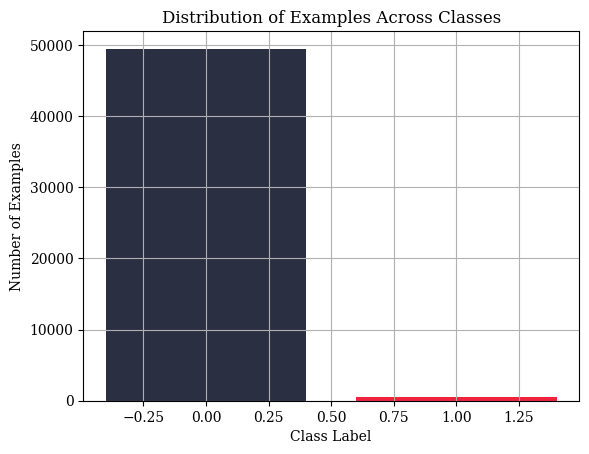

In [6]:
class_labels, class_counts = np.unique(Y, return_counts=True)
colors = ["#2B2F42", "#EF233C"]
plt.bar(class_labels, class_counts, color= colors)
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Examples Across Classes')
plt.grid()
plt.show()

## **Feature elimination: Variable inflation Factor**

In [7]:
# 11
def calculate_vif(df, threshold=10):
    """Calculate VIF and iteratively remove features with high VIF values."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]


    while vif_data["VIF"].max() > threshold:
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Removing {max_vif_feature} with VIF {vif_data['VIF'].max():.2f}")

        df = df.drop(columns=[max_vif_feature])


        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print("Final features after VIF elimination:")
    print(vif_data)
    return df

X_reduced = calculate_vif(X.copy(), threshold=5)

print(Y.shape)
print(X_reduced.shape)

Y = Y[X_reduced.index]

print(Y.shape)
print(X_reduced.shape)

X_train, X_test, y_train, y_test = train_test_split(
   X_reduced, Y, test_size=0.33, random_state=2024, stratify = Y)

Removing sales_6_month with VIF 55.18
Removing forecast_6_month with VIF 27.92
Removing sales_3_month with VIF 20.50
Removing perf_12_month_avg with VIF 12.27
Removing sales_1_month with VIF 8.85
Removing forecast_9_month with VIF 7.97
Final features after VIF elimination:
             Feature       VIF
0       national_inv  1.025048
1          lead_time  1.067885
2     in_transit_qty  2.280936
3   forecast_3_month  2.336416
4      sales_9_month  2.386766
5           min_bank  3.754253
6    pieces_past_due  1.062057
7   perf_6_month_avg  1.173806
8       local_bo_qty  1.073694
9    potential_issue  1.004960
10         deck_risk  1.456493
11     oe_constraint  1.001922
12         ppap_risk  1.144044
13     stop_auto_buy  2.821066
14          rev_stop  1.002246
(50000,)
(50000, 15)
(50000,)
(50000, 15)


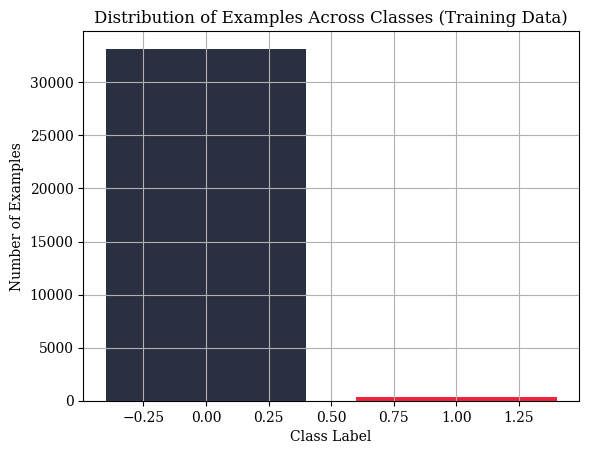

In [8]:
class_labels, class_counts = np.unique(y_train, return_counts=True)

plt.bar(class_labels, class_counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Examples Across Classes (Training Data)')
plt.grid()
plt.show()

## **Min-Max normalization**

In [9]:
# 12
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)

print("Min value in normalized X_train:", X_train_normalized.min().min())
print("Max value in normalized X_train:", X_train_normalized.max().max())

Min value in normalized X_train: 0.0
Max value in normalized X_train: 1.0


In [10]:
# 13
X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
X_test_normalized = X_test_normalized.clip(0, 1)
print("Min value in normalized X_test after clipping:", X_test_normalized.min().min())
print("Max value in normalized X_test after clipping:", X_test_normalized.max().max())

Min value in normalized X_test after clipping: 0.0
Max value in normalized X_test after clipping: 1.0


## **Deep Neural Network**

In [11]:
def make_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        # layers.Dense(512, activation='relu', name='Dense_512'),
        # layers.BatchNormalization(),
        layers.Dropout(0.1, name='Dropout_1'),
        layers.Dense(256, activation='relu', name='Dense_256'),
        layers.BatchNormalization(),
        layers.Dropout(0.1, name='Dropout_2'),
        layers.Dense(128, activation='relu', name='Dense_128'),
        layers.BatchNormalization(),
        layers.Dropout(0.1, name='Dropout_3'),
        layers.Dense(64, activation='relu', name='Dense_64'),
        layers.BatchNormalization(),
        layers.Dropout(0.1, name='Dropout_4'),
        layers.Dense(32, activation='relu', name='Dense_32'),
        layers.BatchNormalization(),
        layers.Dropout(0.5, name='Dropout_5'),
        layers.Dense(1, activation='sigmoid', name='Output')])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy'])
    return model

input_dim = X_train_normalized.shape[1]
model = make_model(input_dim)

def visualize_model_graph(model):
    dot = graphviz.Digraph(format='png')
    dot.node('Input', 'Input Layer\n' + str(input_dim) + ' Features', shape='box', color='lightblue')

    for idx, layer in enumerate(model.layers):
        layer_name = layer.name
        if isinstance(layer, layers.Dense):
            dot.node(layer_name, f'{layer_name}\n{layer.units} Neurons', shape='ellipse')
        elif isinstance(layer, layers.Dropout):
            dot.node(layer_name, layer_name, shape='diamond')

        if idx == 0:
            dot.edge('Input', layer_name)
        else:
            dot.edge(model.layers[idx - 1].name, layer_name)

    output_layer = model.layers[-1].name
    dot.node('Output', 'Output Layer\n1 Neuron', shape='ellipse', color='lightgreen')
    dot.edge(output_layer, 'Output')

    return dot

dnn_graph = visualize_model_graph(model)
dnn_graph.render('dnn_model_graph')
dnn_graph.view()

'dnn_model_graph.png'

## **Model metrics**

In [12]:
METRICS = [
    metrics.BinaryCrossentropy(name='cross_entropy'),
    metrics.MeanSquaredError(name='brier_score'),
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'),
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')]

## **DNN model**

In [13]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    input_dim = X_train_normalized.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation=layers.LeakyReLU()), # Changed: Instantiate LeakyReLU
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(256, activation=layers.LeakyReLU()),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(128, activation=layers.LeakyReLU()),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(64, activation=layers.LeakyReLU()),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(32, activation=layers.LeakyReLU()),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    model.compile(
        optimizer=optimizers.AdamW(learning_rate=1e-3),
        loss=losses.BinaryCrossentropy(),
        metrics=METRICS)

    return model

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=3,
        mode='max',
        restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,625 (729.00 KB)

 Trainable params: 184,705 (721.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
model.predict(X_train_normalized[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.67585367],
       [0.675849  ],
       [0.6738967 ],
       [0.68912697],
       [0.679142  ],
       [0.6671458 ],
       [0.6699219 ],
       [0.67640185],
       [0.6763484 ],
       [0.67231405]], dtype=float32)

In [15]:
BATCH_SIZE = 2048
EPOCHS = 100

X_train_array = X_train_normalized.to_numpy() if isinstance(X_train_normalized, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)

print("X_train shape:", X_train_array.shape)
print("Train labels shape:", y_train_array.shape)

results = model.evaluate(X_train_array, y_train_array, batch_size=BATCH_SIZE, verbose=0)

print(f"Loss: {results[0]:0.4f}")

X_train shape: (33500, 15)
Train labels shape: (33500, 1)
Loss: 1.1175


In [16]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias

Examples:
    Total: 33500
    Positive: 336 (1.00% of total)



array([-4.59210907])

**Set that as the initial bias, and the model will give much more reasonable initial guesses. It should be near: pos/total = 0.0100**

In [17]:
pos/total

0.010029850746268656

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(X_train_normalized[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


array([[0.01065848],
       [0.01022583],
       [0.01005608],
       [0.01014075],
       [0.01045399],
       [0.00990553],
       [0.00996958],
       [0.01050893],
       [0.00981177],
       [0.01003622]], dtype=float32)

In [19]:
results = model.evaluate(X_train_normalized, y_train_array, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0565


When dealing with highly imbalanced data, setting an appropriate bias in the output layer helps the model to converge faster and more effectively, as it begins with a prediction distribution that reflects the class imbalance. This technique helps reduce the loss significantly right from the start, as seen in the difference between 1.1175 (random initialization) and 0.0565 (using an informed bias).

- **Without Output Bias: High initial loss (1.1175) due to lack of information on class distribution**
- **With Output Bias: Low initial loss (0.0565) as the model starts with an informed understanding of class imbalance, leading to better initial predictions**

In [20]:
X_test_array = X_test_normalized.to_numpy() if isinstance(X_test_normalized, pd.DataFrame) else X_test
y_test_array = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test

print("X_test shape:", X_test_array.shape)
print("Test labels shape:", y_test_array.shape)

X_test shape: (16500, 15)
Test labels shape: (16500, 1)


In [21]:
import os, tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

In [22]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

y_train_array = y_train_array.reshape(-1, 1) if y_train_array.ndim == 1 else y_train_array
y_test_array = y_test_array.reshape(-1, 1) if y_test_array.ndim == 1 else y_test_array

print("X_train shape:", X_train_array.shape)
print("Train labels shape:", y_train_array.shape)
print("X_test shape:", X_test_array.shape)
print("Test labels shape:", y_test_array.shape)

zero_bias_history = model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    verbose=0)

X_train shape: (33500, 15)
Train labels shape: (33500, 1)
X_test shape: (16500, 15)
Test labels shape: (16500, 1)


In [23]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    verbose=0)

In [24]:
import matplotlib.pyplot as plt

def plot_loss(history, label, n):
  colors = ['blue', 'green', 'red', 'orange']

  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

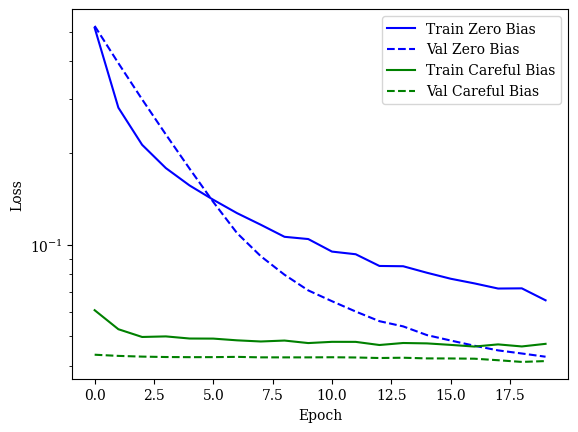

In [25]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [26]:
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

baseline_history = model.fit(
    X_train_array,
    y_train_array,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_array, y_test_array))

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9903 - auc: 0.8570 - brier_score: 0.0092 - cross_entropy: 0.0442 - fn: 186.3889 - fp: 0.5556 - loss: 0.0442 - prc: 0.0736 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 19009.0547 - tp: 0.0000e+00 - val_accuracy: 0.9899 - val_auc: 0.8727 - val_brier_score: 0.0098 - val_cross_entropy: 0.0509 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0509 - val_prc: 0.1058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 16334.0000 - val_tp: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9901 - auc: 0.8563 - brier_score: 0.0093 - cross_entropy: 0.0445 - fn: 185.3889 - fp: 5.7778 - loss: 0.0445 - prc: 0.0674 - precision: 0.1580 - recall: 0.0097 - tn: 19003.8340 - tp: 1.0000 - val_accuracy: 0.9899 - val_auc: 0.8702 - val_brier_score: 0.0098 - val_cross_entropy: 0.0504 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0504 - val_prc: 0.1037 - val_precision: 0.0000e+00 - val_rec

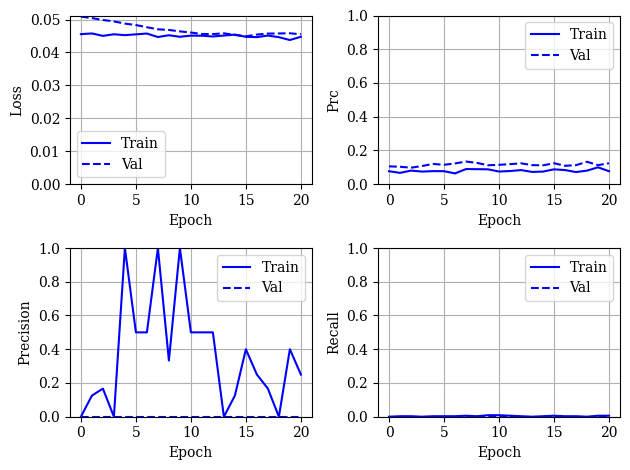

In [27]:
def plot_metrics(history):
  colors = ['blue', 'green', 'red', 'orange']
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend(), plt.grid(),
    plt.tight_layout()

plot_metrics(baseline_history)

In [28]:
train_predictions_baseline = model.predict(X_train_array, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test_array, batch_size=BATCH_SIZE)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [29]:
def plot_cm(labels, predictions, threshold=0.5):
    predicted_labels = (predictions > threshold).astype(int)
    cm = confusion_matrix(labels, predicted_labels)

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f'DNN Model Confusion Matrix @ {threshold:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    tn, fp, fn, tp = cm.ravel()

    print(f'Correctly predicted "No Backorder" (True Negatives): {tn}')
    print(f'Incorrectly predicted "Backorder" (False Positives): {fp} (false alarm)')
    print(f'Incorrectly predicted "No Backorder" (False Negatives): {fn} (missed backorder)')
    print(f'Correctly predicted "Backorder" (True Positives): {tp}')
    print(f'Total Actual Backorders: {np.sum(cm[1])}')

    plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions_baseline_labels = (test_predictions_baseline > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_baseline_labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



loss :  0.045523662120103836
compile_metrics :  0.045523662120103836

Correctly predicted "No Backorder" (True Negatives): 16334
Incorrectly predicted "Backorder" (False Positives): 0 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 166 (missed backorder)
Correctly predicted "Backorder" (True Positives): 0
Total Actual Backorders: 166


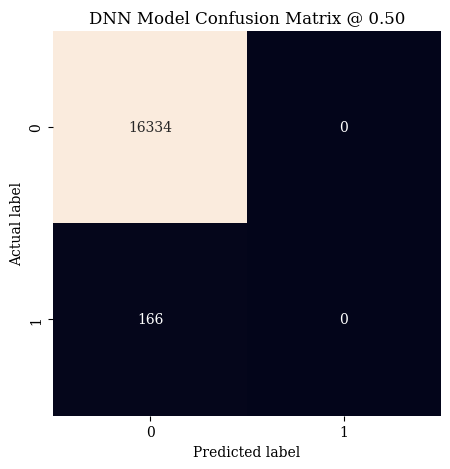

In [31]:
from sklearn.metrics import confusion_matrix

baseline_results = model.evaluate(X_test_array, y_test_array,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test_array, test_predictions_baseline)

## **Weighted model**

## Calculate class weights
The goal is to identify backorder, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold.

In [32]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 49.85


In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)


weighted_history = weighted_model.fit(
    X_train_array,
    y_train_array[:X_train_array.shape[0]],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_array, y_test_array),
    class_weight=class_weight)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.9571 - auc: 0.7813 - brier_score: 0.0349 - cross_entropy: 0.1467 - fn: 287.6667 - fp: 1454.3334 - loss: 1.5097 - prc: 0.0342 - precision: 0.0340 - recall: 0.1517 - tn: 33889.2773 - tp: 64.7222 - val_accuracy: 0.9899 - val_auc: 0.8382 - val_brier_score: 0.0099 - val_cross_entropy: 0.0535 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0535 - val_prc: 0.0734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 16334.0000 - val_tp: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8539 - auc: 0.8271 - brier_score: 0.1171 - cross_entropy: 0.4805 - fn: 71.2222 - fp: 2682.0000 - loss: 0.8379 - prc: 0.0420 - precision: 0.0396 - recall: 0.6089 - tn: 16327.6113 - tp: 115.1667 - val_accuracy: 0.9899 - val_auc: 0.8465 - val_brier_score: 0.0099 - val_cross_entropy: 0.0553 - val_fn: 166.0000 - val_fp: 0.0000e+00 - val_loss: 0.0553 - val_prc: 0.0705 - val_precision: 0.0000e+00 - val_recall

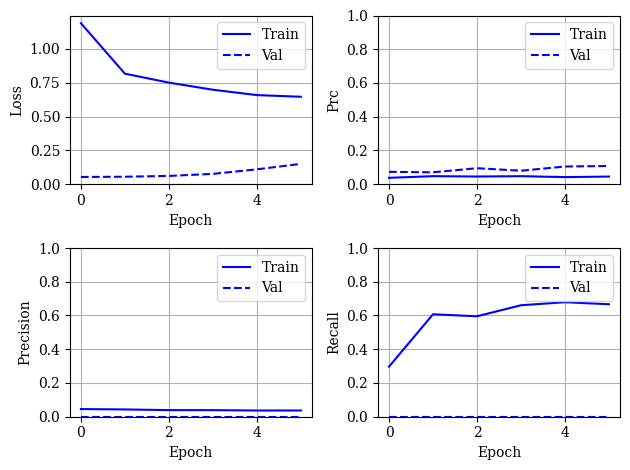

In [34]:
plot_metrics(weighted_history)

In [35]:
train_predictions_weighted = weighted_model.predict(X_train_array, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_array, batch_size=BATCH_SIZE)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [36]:
from sklearn.metrics import confusion_matrix,classification_report

test_predictions_weighted_labels = (test_predictions_weighted > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_weighted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix_result = confusion_matrix(y_test_array, test_predictions_weighted_labels)
print(confusion_matrix_result)

[[16334     0]
 [  166     0]]


loss :  0.15047168731689453
compile_metrics :  0.15047168731689453

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


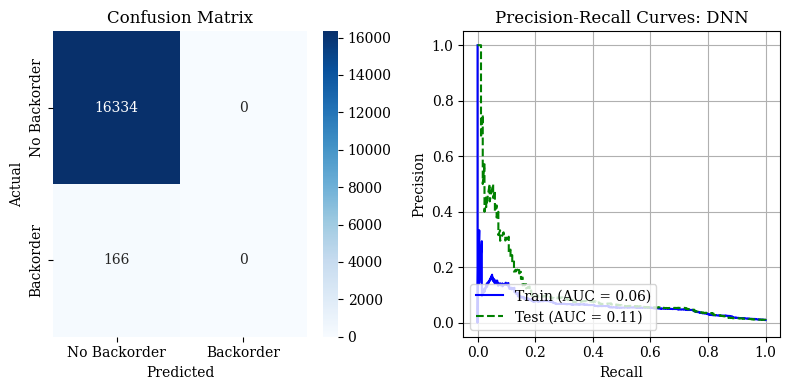

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Assuming weighted_model is your trained model and you're using the evaluation function
weighted_results = weighted_model.evaluate(X_test_array,
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)

# Print evaluation results
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

# 1. Classification report
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_weighted_labels))

# 2. Confusion matrix
cm = confusion_matrix(y_test_array, test_predictions_weighted_labels)

# Define colors for plots
colors = ['b', 'g']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 3. Confusion matrix heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# 4. Precision-Recall Curves
def plot_prc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    prc_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')

# Plotting Precision-Recall curves
plot_prc("Train", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_prc("Test", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('Precision-Recall Curves: DNN')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


loss :  0.15047168731689453
compile_metrics :  0.15047168731689453

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


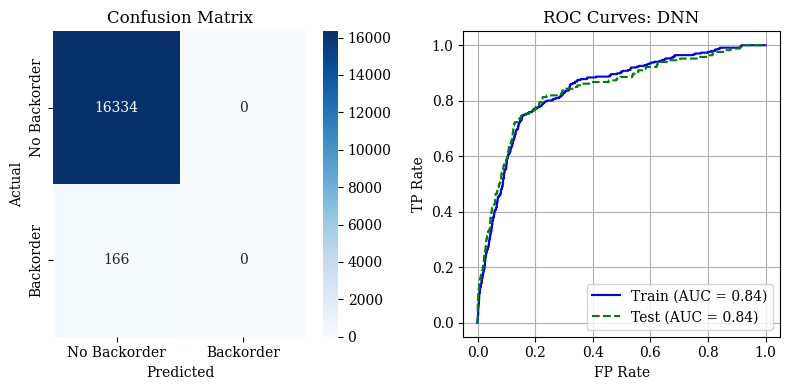

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

weighted_results = weighted_model.evaluate(X_test_array,
                                           y_test_array,
                                           batch_size=BATCH_SIZE,
                                           verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

# 1. Classification report
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_weighted_labels))

# 2. Confusion matrix
cm = confusion_matrix(y_test_array, test_predictions_weighted_labels)

# Define colors for plots
colors = ['b', 'g']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 3. Confusion matrix heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# 4. ROC Curves
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

# Plotting ROC curves
plot_roc("Train", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_roc("Test", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves: DNN')
axes[1].set_xlabel('FP Rate')
axes[1].set_ylabel('TP Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import precision_recall_curve, auc

def plot_prc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    prc_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')

plot_prc("Train", y_train_array, train_predictions_weighted, color=colors[0], ax=axes[1])
plot_prc("Test", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--', ax=axes[1])
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

loss :  0.15047168731689453
compile_metrics :  0.15047168731689453

Correctly predicted "No Backorder" (True Negatives): 16334
Incorrectly predicted "Backorder" (False Positives): 0 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 166 (missed backorder)
Correctly predicted "Backorder" (True Positives): 0
Total Actual Backorders: 166


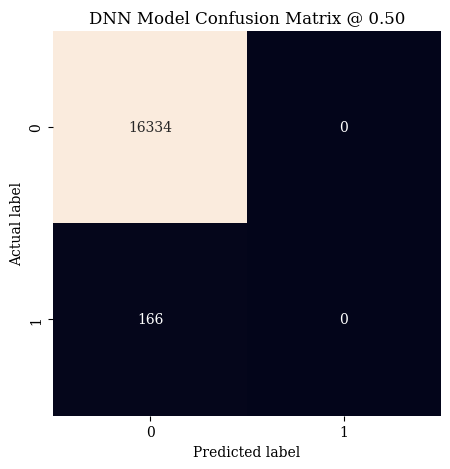

In [41]:
weighted_results = weighted_model.evaluate(X_test_array, y_test_array,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()
plot_cm(y_test_array, test_predictions_weighted)

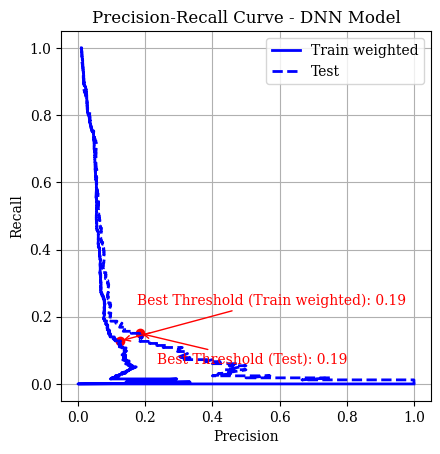

In [42]:
def plot_prc(name, labels, predictions, offset_x=0.05, offset_y=0.05, **kwargs):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, predictions)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold_index = f1_scores.argmax()
    best_threshold = thresholds[best_threshold_index]
    best_precision = precision[best_threshold_index]
    best_recall = recall[best_threshold_index]

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.scatter(best_precision, best_recall, color='red', marker='o')
    plt.annotate(
        f'Best Threshold ({name}): {best_threshold:.2f}',
        xy=(best_precision, best_recall),
        xytext=(best_precision + offset_x, best_recall + offset_y),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10,
        color='red',
        verticalalignment='bottom'
    )

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return best_threshold

best_threshold_train = plot_prc("Train weighted", y_train.values, train_predictions_weighted, color='blue', offset_y=0.1)
best_threshold_test = plot_prc("Test", y_test.values, test_predictions_weighted, color='blue', linestyle='--', offset_y=-0.1)

plt.legend(loc='upper right')
plt.title("Precision-Recall Curve - DNN Model")
plt.show()

Correctly predicted "No Backorder" (True Negatives): 16334
Incorrectly predicted "Backorder" (False Positives): 0 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 166 (missed backorder)
Correctly predicted "Backorder" (True Positives): 0
Total Actual Backorders: 166


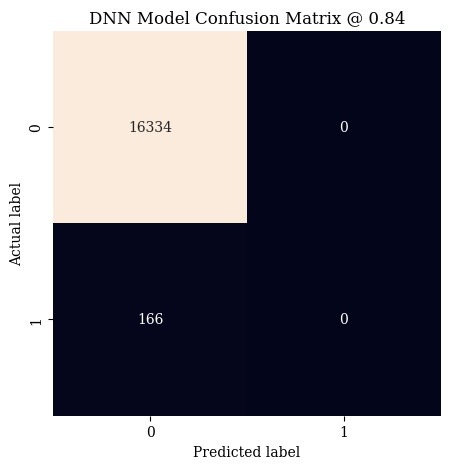

In [43]:
plot_cm(y_test_array, test_predictions_weighted, threshold=0.84)

## **Oversampled**

In [44]:
y_train_array = np.array(y_train).reshape(-1, 1)
bool_train_labels = y_train_array[:, 0] != 0
y_test_array = np.array(y_test).reshape(-1, 1)

In [45]:
X_train = X_train_normalized.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

pos_features = X_train.loc[bool_train_labels]
neg_features = X_train.loc[~bool_train_labels]

pos_labels = y_train.loc[bool_train_labels]
neg_labels = y_train.loc[~bool_train_labels]

In [46]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features), replace=True)
res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels.iloc[choices]
print(res_pos_features.shape)
print(res_pos_labels.shape)

(33164, 15)
(33164,)


In [47]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(66328, 15)

In [52]:
BUFFER_SIZE = len(resampled_features)
BATCH_SIZE = 2048

def make_ds(features, labels, batch_size=None):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  # Reshape labels to (None, 1) using tf.expand_dims
  ds = ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1))) # add this line to reshape the labels
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  if batch_size: # Apply batching only if batch_size is provided
    ds = ds.batch(BATCH_SIZE)
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [53]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [0.74325764 0.93006894 0.90310595 0.91434159 0.67495972 0.3543139
 0.         0.88429978 0.         0.         0.         0.
 1.         1.         0.        ]

Label:  [1]


In [54]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch

print(resampled_steps_per_epoch)

0.5107421875
33


In [55]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_test_array, y_test_array)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.7730 - auc: 0.8368 - brier_score: 0.1650 - cross_entropy: 0.5188 - fn: 5143.7061 - fp: 5729.0884 - loss: 0.6049 - prc: 0.8073 - precision: 0.7664 - recall: 0.7848 - tn: 18462.7051 - tp: 18988.2656 - val_accuracy: 0.1205 - val_auc: 0.8313 - val_brier_score: 0.2800 - val_cross_entropy: 0.7533 - val_fn: 4.0000 - val_fp: 14507.0000 - val_loss: 0.7533 - val_prc: 0.1025 - val_precision: 0.0110 - val_recall: 0.9759 - val_tn: 1827.0000 - val_tp: 162.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.8038 - auc: 0.8685 - brier_score: 0.1446 - cross_entropy: 0.4549 - fn: 3210.2942 - fp: 3783.4119 - loss: 0.4549 - prc: 0.8475 - precision: 0.7951 - recall: 0.8200 - tn: 14070.1768 - tp: 14715.8828 - val_accuracy: 0.0333 - val_auc: 0.8410 - val_brier_score: 0.3230 - val_cross_entropy: 0.8405 - val_fn: 0.0000e+00 - val_fp: 15951.0000 - val_loss: 0.8405 - val_prc: 0.0794 - val_precision: 0.0103 - val_recall: 1.000

In [56]:
def plot_metrics(history):
  colors = ['blue', 'green']
  metrics = ['loss', 'prc', 'precision', 'recall']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend(), plt.grid()
    plt.tight_layout()

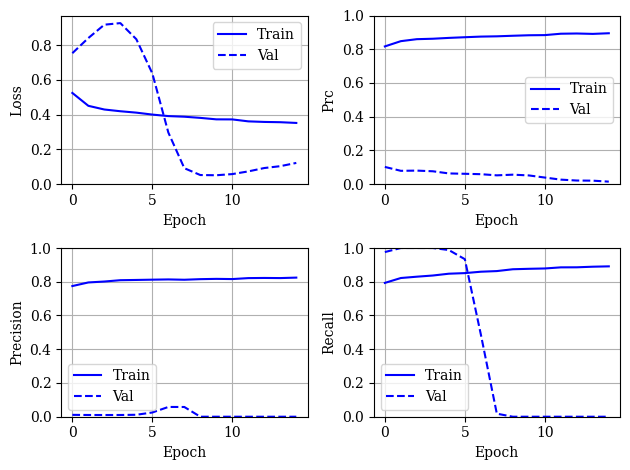

In [57]:
plot_metrics(resampled_history)

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

# Break up the epochs into smaller chunks
smaller_epochs = 10
total_epochs = EPOCHS

for i in range(total_epochs // smaller_epochs):
    resampled_history = resampled_model.fit(
        resampled_ds,
        epochs=smaller_epochs,
        steps_per_epoch=resampled_steps_per_epoch,
        validation_data=(val_ds),
        callbacks=[early_stopping])

    # Check if EarlyStopping triggered and break if necessary
    if resampled_model.stop_training:
        print("Early stopping triggered. Training stopped.")
        break

    # Log key metrics
    train_loss = resampled_history.history['loss'][-1]
    val_loss = resampled_history.history['val_loss'][-1]
    print(f"Epoch chunk {i+1}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.8389 - auc: 0.8985 - brier_score: 0.1174 - cross_entropy: 0.4038 - fn: 4565.7939 - fp: 4371.7354 - loss: 0.6050 - prc: 0.7561 - precision: 0.7316 - recall: 0.7124 - tn: 29859.0586 - tp: 13483.1768 - val_accuracy: 0.0512 - val_auc: 0.8363 - val_brier_score: 0.2899 - val_cross_entropy: 0.7733 - val_fn: 0.0000e+00 - val_fp: 15656.0000 - val_loss: 0.7733 - val_prc: 0.0935 - val_precision: 0.0105 - val_recall: 1.0000 - val_tn: 678.0000 - val_tp: 166.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.8022 - auc: 0.8673 - brier_score: 0.1450 - cross_entropy: 0.4551 - fn: 3244.3235 - fp: 3797.0588 - loss: 0.4551 - prc: 0.8428 - precision: 0.7941 - recall: 0.8174 - tn: 14056.5293 - tp: 14681.8525 - val_accuracy: 0.0193 - val_auc: 0.8482 - val_brier_score: 0.3538 - val_cross_entropy: 0.9044 - val_fn: 0.0000e+00 - val_fp: 16182.0000 - val_loss: 0.9044 - val_prc: 0.0937 - val_precision: 0.0102 - val_recall: 1.00

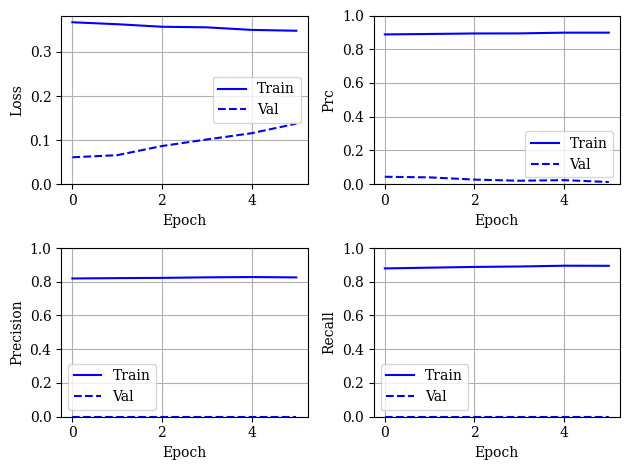

In [59]:
plot_metrics(resampled_history)

In [60]:
train_predictions_resampled = resampled_model.predict(resampled_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test_array, batch_size=BATCH_SIZE)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [61]:
from sklearn.metrics import confusion_matrix,classification_report

test_predictions_resampled_labels = (test_predictions_resampled > 0.5).astype(int)
print(classification_report(y_test_array, test_predictions_resampled_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16334
           1       0.00      0.00      0.00       166

    accuracy                           0.99     16500
   macro avg       0.49      0.50      0.50     16500
weighted avg       0.98      0.99      0.98     16500



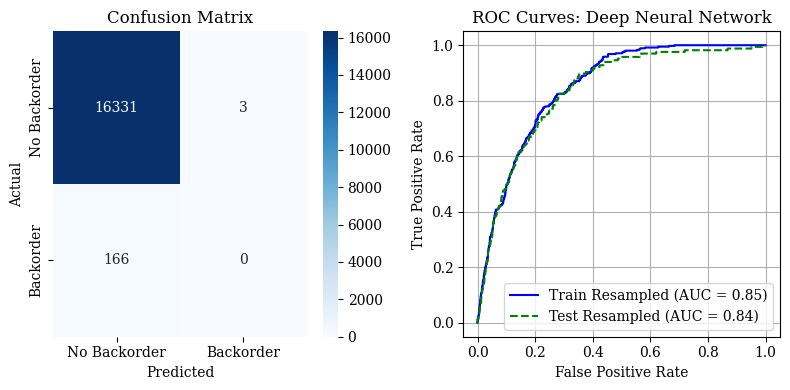

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# # Binary conversion for predictions
# test_predictions_resampled_binary = np.where(test_predictions_resampled > 0.5, 1, 0)

# 1. Classification report
print("Classification Report:")
print(classification_report(y_test_array, test_predictions_resampled_labels))

# 2. Confusion matrix
cm = confusion_matrix(y_test_array, test_predictions_resampled_labels)

# Define colors for plots
colors = ['b', 'g']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 3. Confusion matrix heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No Backorder', 'Backorder'],
    yticklabels=['No Backorder', 'Backorder'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# 4. ROC Curves
def plot_roc(label, true_labels, predictions, color, linestyle='-', ax=None):
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

# Plotting ROC curves
plot_roc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[0], ax=axes[1])
plot_roc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[1], linestyle='--', ax=axes[1])

axes[1].set_title('ROC Curves: Deep Neural Network')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

loss :  0.13738487660884857
compile_metrics :  0.13738487660884857

Correctly predicted "No Backorder" (True Negatives): 16331
Incorrectly predicted "Backorder" (False Positives): 3 (false alarm)
Incorrectly predicted "No Backorder" (False Negatives): 166 (missed backorder)
Correctly predicted "Backorder" (True Positives): 0
Total Actual Backorders: 166


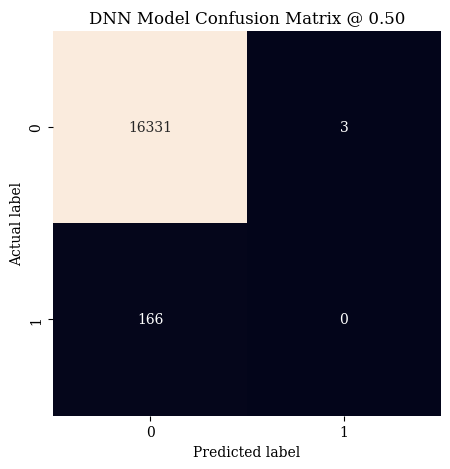

In [63]:
resampled_results = resampled_model.evaluate(X_test_array, y_test_array,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(y_test_array, test_predictions_resampled)

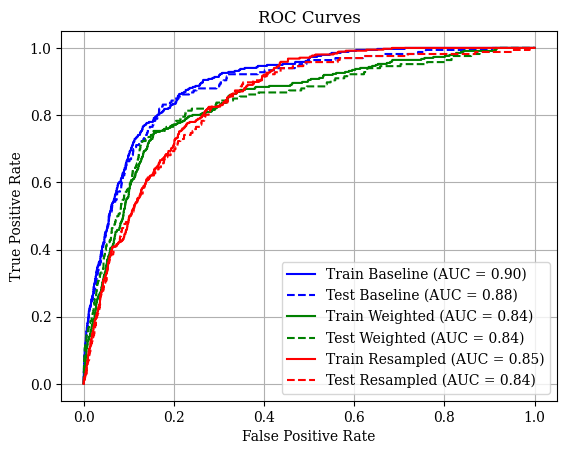

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def plot_roc(label, true_labels, predictions, color, linestyle='-'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc("Train Baseline", y_train_array, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test_array, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", y_train_array, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[2], linestyle='--')

plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [65]:
confusion_matrix_result = confusion_matrix(y_test_array, test_predictions_resampled_labels)
print(confusion_matrix_result)

[[16331     3]
 [  166     0]]


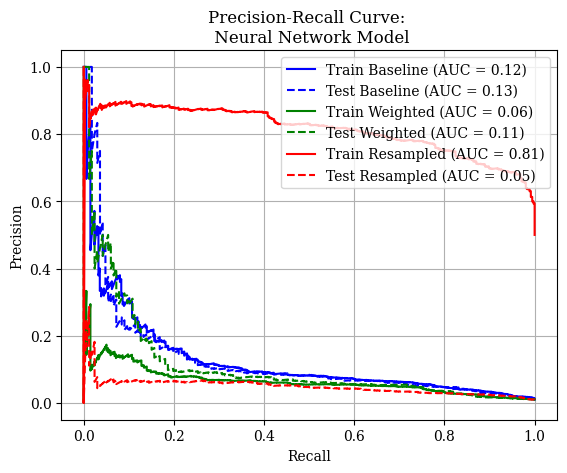

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_prc(label, y_true, y_scores, color, linestyle='-'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = auc(recall, precision)

    plt.plot(recall, precision, color=color, linestyle=linestyle, label=f'{label} (AUC = {prc_auc:.2f})')
colors = ['b', 'g', 'r']

plot_prc("Train Baseline", y_train_array, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test_array, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train_array, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test_array, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", resampled_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test_array, test_predictions_resampled, color=colors[2], linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: \n Neural Network Model')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()